In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

https://docs.google.com/document/d/1l1M9-JBg9ztoU4M7SHKt9XXBrQBvpKYWQtSWUJAfO2Q/edit?tab=t.0

## Levantamento Feriados

### Scraping e filtrar

In [ ]:
url =  {
    2023: 'https://busca.tjsc.jus.br/buscatextual/integra.do?cdSistema=1&cdDocumento=183366&cdCategoria=1&q=&frase=Consolida%20o%20calend%E1rio%20de%20feriados&excluir=&qualquer=&prox1=&prox2=&proxc=',
    2024: 'https://busca.tjsc.jus.br/buscatextual/integra.do?cdSistema=1&cdDocumento=184842&cdCategoria=1&q=&frase=Consolida%20o%20calend%E1rio%20de%20feriados&excluir=&qualquer=&prox1=&prox2=&proxc=',
    2025: 'https://busca.tjsc.jus.br/buscatextual/integra.do?cdSistema=1&cdDocumento=187470&cdCategoria=1&q=&frase=Consolida%20o%20calend%E1rio%20de%20feriados&excluir=&qualquer=&prox1=&prox2=&proxc='
    } 

dfs = []

for i in range(2023, 2025 + 1):
    
    response = requests.get(url[i])

    if response.status_code == 200:
        html = BeautifulSoup(response.text, 'html')
        df = pd.read_html(str(html),header=0)[1]
        df['ano'] = i
        
        dfs.append(df)

In [42]:
df = pd.concat(dfs)
df = df[df['Comarcas afetadas'].str.contains('Tribunal de Justiça')]

meses_map = {
    'janeiro': '01', 'fevereiro': '02', 'março': '03', 'abril': '04',
    'maio': '05', 'junho': '06', 'julho': '07', 'agosto': '08',
    'setembro': '09', 'outubro': '10', 'novembro': '11', 'dezembro': '12'
}

# 2. Limpeza da coluna Data
# Removemos o '°', o '.' e garantimos que tudo esteja em minúsculo
df['Data_Limpa'] = df['Data'].str.replace('°', '', regex=False).str.replace('.', '', regex=False).str.lower()

# 3. Separar o dia do mês (removendo o " de ")
# Ex: "1 de janeiro" ou "1 de janeiro" viram ["1", "janeiro"]
df_temp = df['Data_Limpa'].str.replace(' de ', ' ', regex=False).str.split(' ', expand=True)
df_temp.columns = ['dia', 'mes_nome']

# 4. Montar a data final
df['mes_num'] = df_temp['mes_nome'].map(meses_map)
df['dia_num'] = df_temp['dia'].str.zfill(2) # Garante o '01'

# Criar a coluna no padrão Brasil
df['data_formatada'] = df['dia_num'] + '/' + df['mes_num'] + '/' + df['ano'].astype(str)

# Limpar colunas temporárias para o dataframe ficar bonito
df = df.drop(columns=['Data_Limpa', 'mes_num', 'dia_num'])

In [ ]:

df['data_dt'] = pd.to_datetime(df['data_formatada'], format='%d/%m/%Y')
df = df.sort_values(by='data_dt')

# 1. Dicionário de tradução dos dias da semana
dias_map = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# 2. Criar a coluna com o nome em inglês e traduzir logo em seguida
df['dia_semana_nome'] = df['data_dt'].dt.day_name().map(dias_map)



In [49]:
df.to_csv('data/Feriados/feriados_filtrados.csv', index=False)

### Fazer a análise do df extraído

In [52]:
# 1. Definir os períodos de recesso (conforme você enviou)
recessos = [
    ("2019-12-20", "2020-01-06"), ("2020-12-21", "2021-01-06"),
    ("2021-12-20", "2022-01-06"), ("2022-12-20", "2023-01-06"),
    ("2023-12-20", "2024-01-05"), ("2024-12-20", "2025-01-06"),
    ("2025-12-22", "2026-01-06")
]

def esta_no_recesso(data):
    for inicio, fim in recessos:
        if pd.to_datetime(inicio) <= data <= pd.to_datetime(fim):
            return True
    return False

# 2. Criar colunas de identificação
# Identifica Sábado (5) e Domingo (6)
df['cai_fds'] = df['data_dt'].dt.dayofweek.isin([5, 6])

# Identifica se está no recesso
df['cai_recesso'] = df['data_dt'].apply(esta_no_recesso)

# 3. A Lógica do Insight: "Dia de Folga Real"
# Só é um "dia de folga real" se: NÃO for fim de semana E NÃO estiver no recesso
df['folga_efetiva'] = (~df['cai_fds']) & (~df['cai_recesso'])

# 4. Agrupar os resultados por ano
insights = df.groupby('ano').agg(
    total_feriados=('Data', 'count'),
    feriados_no_fds=('cai_fds', 'sum'),
    feriados_no_recesso=('cai_recesso', 'sum'),
    dias_folga_reais=('folga_efetiva', 'sum')
).reset_index()

# Renomear para o padrão do seu relatório
insights.columns = ['Ano', 'Total Feriados', 'Feriados em Sáb/Dom', 'Feriados no Recesso', 'Dias de Folga Efetivos']


In [ ]:
insights.to_csv('data/Feriados/feriados_isights.csv', index=False)

: 

## Levantamento Férias

In [3]:
import tabula

# Extrai todas as tabelas de todas as páginas
lista_tabelas = tabula.read_pdf("arquivo.pdf", pages='all', multiple_tables=True)

# Acessa a primeira tabela extraída
df = lista_tabelas[0]


Got stderr: jan 08, 2026 1:35:58 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
ADVERTÊNCIA: New fonts found, font cache will be re-built
jan 08, 2026 1:35:58 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
ADVERTÊNCIA: Building on-disk font cache, this may take a while
jan 08, 2026 1:35:59 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
ADVERTÊNCIA: Finished building on-disk font cache, found 358 fonts



In [5]:
import pdfplumber
import pandas as pd

pdf_path = "arquivo.pdf"

all_data = []

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        # O segredo está no table_settings para ignorar linhas de texto fora da tabela
        table = page.extract_table(table_settings={
            "vertical_strategy": "lines",
            "horizontal_strategy": "lines",
        })
        
        if table:
            # Na primeira página, pegamos o cabeçalho correto (índice 1 no seu PDF)
            if not all_data:
                all_data.extend(table)
            else:
                # Nas outras páginas, ignoramos as linhas de cabeçalho
                all_data.extend(table[2:])

# Criando o DataFrame
df = pd.DataFrame(all_data)

# Tratamento básico para remover quebras de linha que o PDF gera
df = df.replace('\n', ' ', regex=True)

# Opcional: Salvar para conferir
df.to_excel("extracao_tjsc.xlsx", index=False)

In [ ]:
import pdfplumber
import pandas as pd
import os

# Caminho da pasta onde estão os seus PDFs
pasta_pdfs = 'pdfs'
lista_final = []

# 1. Loop para percorrer cada arquivo na pasta
for arquivo in os.listdir(pasta_pdfs):
    if arquivo.endswith('.pdf'):
        caminho_completo = os.path.join(pasta_pdfs, arquivo)
        
        # Extrair o ano do nome do arquivo (ex: "2020.pdf" -> "2020")
        ano_arquivo = arquivo.replace('.pdf', '')
        
        print(f"Processando: {arquivo}...")

        with pdfplumber.open(caminho_completo) as pdf:
            for page in pdf.pages:
                # Extração com estratégia de linhas para manter a estrutura
                table = page.extract_table(table_settings={
                    "vertical_strategy": "lines",
                    "horizontal_strategy": "lines",
                })
                
                if table:
                    # Converter para DataFrame temporário
                    df_temp = pd.DataFrame(table)
                    
                    # Adicionar a coluna de Ano
                    df_temp['Ano_Documento'] = ano_arquivo
                    
                    lista_final.append(df_temp)

# 2. Unificar todos os dados em um único DataFrame
if lista_final:
    df_resultado = pd.concat(lista_final, ignore_index=True)

    # 3. Tratamentos de Limpeza
    # Remove linhas que sejam apenas cabeçalhos repetidos (ex: onde a célula tem "Matrícula")
    df_resultado = df_resultado[df_resultado[0] != "Matrícula"]
    
    # Remove quebras de linha dentro das células
    df_resultado = df_resultado.replace('\n', ' ', regex=True).strip()



Processando: 2020.pdf...
Processando: 2021.pdf...
Processando: 2022.pdf...
Processando: 2023.pdf...


AttributeError: 'DataFrame' object has no attribute 'strip'

In [9]:
import pdfplumber
import pandas as pd
import os

pasta_pdfs = 'pdfs'
lista_final = []

for arquivo in sorted(os.listdir(pasta_pdfs)):
    if arquivo.endswith('.pdf'):
        caminho_completo = os.path.join(pasta_pdfs, arquivo)
        ano_arquivo = arquivo.replace('.pdf', '')
        
        print(f"Processando: {arquivo}...")

        with pdfplumber.open(caminho_completo) as pdf:
            for i, page in enumerate(pdf.pages):
                table = page.extract_table(table_settings={
                    "vertical_strategy": "lines",
                    "horizontal_strategy": "lines",
                })
                
                if not table:
                    continue

                # TRATAMENTO PARA A PRIMEIRA PÁGINA: Criar o cabeçalho correto
                if i == 0:
                    # Mesclamos a Linha 0 (Matrícula, Magistrado) com a Linha 1 (1º Período, 2º Período)
                    # Resultado esperado: ['Matrícula', 'Magistrado', '1º Período', '2º Período']
                    cabecalho = [
                        "Matrícula", 
                        "Magistrado", 
                        table[1][2], # Pega '1º Período' da segunda linha
                        table[1][3]  # Pega '2º Período' da segunda linha
                    ]
                    # Dados começam a partir da linha 2
                    dados = table[2:]
                else:
                    # NAS OUTRAS PÁGINAS: Pulamos as linhas de cabeçalho que o PDF repetir
                    # Geralmente são as 2 primeiras linhas também
                    dados = table[2:]

                df_temp = pd.DataFrame(dados, columns=cabecalho)
                df_temp['Ano_Documento'] = ano_arquivo
                lista_final.append(df_temp)

# Unificar e Limpar
if lista_final:
    df_resultado = pd.concat(lista_final, ignore_index=True)
    
    # Remove linhas vazias ou que capturaram lixo do PDF
    df_resultado = df_resultado.dropna(subset=['Matrícula'])
    df_resultado = df_resultado[df_resultado['Matrícula'] != ""]
    
    # Limpa quebras de linha (\n) para o Excel ficar organizado
    df_resultado = df_resultado.replace('\n', ' ', regex=True)



Processando: 2020.pdf...
Processando: 2021.pdf...
Processando: 2022.pdf...
Processando: 2023.pdf...


In [11]:
df_resultado.to_csv('Dados férias magistrados.csv', index=False)

In [15]:
df =df_resultado

In [16]:
import pandas as pd
import re
from datetime import datetime

def calcular_total_dias(texto):
    if not texto or texto == 'None':
        return 0
    
    # Busca padrões do tipo "DD/MM a DD/MM/AAAA" ou "DD/MM a DD/MM"
    # O regex identifica pares de datas
    padrao = r'(\d{2}/\d{2})\s+a\s+(\d{2}/\d{2}/?\d{0,4})'
    intervalos = re.findall(padrao, str(texto))
    
    total_dias = 0
    for inicio_str, fim_str in intervalos:
        try:
            # Tratamento para datas que não têm o ano no meio da string
            # Pegamos o ano final da string completa do fim_str
            ano_match = re.search(r'\d{4}', fim_str)
            ano = ano_match.group() if ano_match else "2023" # fallback seguro
            
            # Limpa as strings para conversão
            inicio_limpo = f"{inicio_str[:5]}/{ano}"
            fim_limpo = fim_str if len(fim_str) > 5 else f"{fim_str}/{ano}"
            
            # Converte para objeto datetime
            d1 = datetime.strptime(inicio_limpo, "%d/%m/%Y")
            d2 = datetime.strptime(fim_limpo, "%d/%m/%Y")
            
            # Cálculo da diferença (incluindo o dia de início: +1)
            total_dias += (d2 - d1).days + 1
        except Exception:
            continue
            
    return total_dias

# 1. Aplicamos a função nas duas colunas de períodos
df['Dias_P1'] = df['1º Período'].apply(calcular_total_dias)
df['Dias_P2'] = df['2º Período'].apply(calcular_total_dias)

# 2. Somamos o total do ano
df['Total_Dias_Ano'] = df['Dias_P1'] + df['Dias_P2']

# 3. Criamos um alerta para quem NÃO cumpriu os 60 dias (ou ultrapassou)
df['Status_60_Dias'] = df['Total_Dias_Ano'].apply(lambda x: "OK" if x == 60 else f"Diferente ({x} dias)")

# Exibindo resultado final agrupado por Magistrado e Ano
resultado_final_60d = df[['Ano_Documento', 'Matrícula', 'Magistrado', 'Total_Dias_Ano', 'Status_60_Dias']]
print(resultado_final_60d.head())

  Ano_Documento Matrícula                 Magistrado  Total_Dias_Ano  \
0          2020      4156               ADEMIR WOLFF              60   
1          2020      5375             ADILOR DANIELI              60   
2          2020      8058             ADRIANA LISBOA              60   
3          2020      5306  ADRIANA MENDES BERTONCINI              60   
4          2020      1801         ALAIDE MARIA NOLLI              60   

  Status_60_Dias  
0             OK  
1             OK  
2             OK  
3             OK  
4             OK  


In [17]:
resumo_anual = df.groupby('Ano_Documento')['Total_Dias_Ano'].mean()
print(resumo_anual)

Ano_Documento
2020    59.923977
2021    59.888268
2022    59.866337
2023    59.942500
Name: Total_Dias_Ano, dtype: float64


In [22]:
resumo_anual.to_csv('Resumo_anual.csv')

## Levantamento Pantão Judiciário

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [3]:
driver = webdriver.Chrome()
driver.get('https://www.tjsc.jus.br/plantao/judiciario-tribunal-de-justica')

In [ ]:
from io import StringIO

html = StringIO(driver.page_source)

In [ ]:
ano_scrapy = 2025

dfs = pd.read_html(html)

df_2025 = pd.concat(dfs)
df_2025['ano'] = ano_scrapy

In [20]:
ano_scrapy = 2024
html = StringIO(driver.page_source)

dfs = pd.read_html(html)[:13]

df_2024 = pd.concat(dfs)
df_2024['ano'] = ano_scrapy

In [27]:
html = StringIO(driver.page_source)
ano_scrapy = 2023
dfs = pd.read_html(html)[13:15]
df_2023 = pd.concat(dfs)
df_2023['ano'] = ano_scrapy

In [80]:
html = StringIO(driver.page_source)
df_2022_2_semestre = pd.read_html(html)[15]
ano_scrapy = 2022
df_2022_2_semestre['ano']= ano_scrapy


In [75]:
df_2022_2_semestre

,Período,Desembargador Plantonista
0,De 7/9 às 12:00 a 14/9 às 8:59,Desa. Ana Lia Moura Lisboa Carneiro (Criminal)...
1,De 14/9 às 19:01 a 21/9 às 8:59,Des. Antônio Zoldan da Veiga (Criminal) Des. ...
2,De 21/9 às 19:01 a 28/9 às 8:59,Des. Luiz Antônio Zanini Fornerolli (Criminal)...
3,De 28/9 às 19:01 a 5/10 às 8:59,Desa. Hildemar Meneguzzi de Carvalho (Criminal...
4,De 5/10 às 19:01 a 12/10 às 11:59,Des. Sidney Eloy Dalabrida (Criminal) Des. Fl...
5,De 12/10 às 12:00 a 19/10 às 8:59,Des. Júlio César Machado Ferreira de Melo (Cri...
6,De 19/10 às 19:01 a 26/10 às 8:59,Des. Norival Acácio Engel (Criminal) Desa. Ha...
7,De 26/10 às 19:01 a 2/11 às 11:59,Des. Luiz César Schweitzer (Criminal) Des. Ál...
8,De 2/11 às 12:00 a 9/11 às 8:59,Des. Ariovaldo Rogerio Ribeiro da Silva (Crimi...
9,De 9/11 às 19:01 a 16/11 às 8:59,Des. Luiz Neri Oliveira de Souza (Criminal) D...


In [56]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

# 1. Ler o arquivo HTML
with open('html.txt', 'r', encoding='utf-8') as f:
    html_content = f.read()

soup = BeautifulSoup(html_content, 'html.parser')

url_base = "https://www.tjsc.jus.br"
anos_alvo = ['2020', '2021', '2022']
lista_documentos = []

# 2. Localizar os cards
cards = soup.find_all('div', class_='card')

for card in cards:
    botao = card.find('button')
    if not botao:
        continue
        
    titulo_card = botao.get_text().strip()
    
    # Verifica se o card é de um dos anos alvo
    # Usamos uma verificação para garantir que pegamos o ano correto
    ano_detectado = None
    for ano in anos_alvo:
        if ano in titulo_card:
            ano_detectado = ano
            break
            
    if ano_detectado:
        # Encontra todos os links dentro deste card
        links = card.find_all('a', href=True)
        
        for link in links:
            href = link['href']
            texto = link.get_text().strip()
            
            # --- CORREÇÃO AQUI ---
            # Em vez de filtrar por '.pdf', filtramos por '/documents/'
            # Isso pega os arquivos mesmo que não tenham a extensão no nome
            if '/documents/' in href:
                url_final = href if href.startswith('http') else url_base + href
                
                lista_documentos.append({
                    'ano': ano_detectado,
                    'mes_descricao': texto,
                    'url': url_final
                })

df_docs = pd.DataFrame(lista_documentos)

print(f"Total de documentos encontrados: {len(df_docs)}")
# Mostra uma amostra para confirmar que pegou 2020 e 2021 sem .pdf
display(df_docs[df_docs['ano'] == '2020'].head(3)) 
display(df_docs.head())

Total de documentos encontrados: 32


,ano,mes_descricao,url
20,2020,Escala de Plantão - Janeiro de 2020 (abre em n...,https://www.tjsc.jus.br/documents/1353653/5151...
21,2020,Escala de Plantão - Fevereiro de 2020 (abre em...,https://www.tjsc.jus.br/documents/1353653/5151...
22,2020,Escala de Plantão - Março de 2020 (abre em nov...,https://www.tjsc.jus.br/documents/1353653/5151...


,ano,mes_descricao,url
0,2022,Escala de Plantão - Janeiro 2022 (abre em nova...,https://www.tjsc.jus.br/documents/1353653/3574...
1,2022,Escala de Plantão - Fevereiro 2022 (abre em no...,https://www.tjsc.jus.br/documents/1353653/1259...
2,2022,Escala de Plantão - Março 2022 (abre em nova a...,https://www.tjsc.jus.br/documents/1353653/1259...
3,2022,Escala de Plantão - Abril 2022 (abre em nova a...,https://www.tjsc.jus.br/documents/1353653/1259...
4,2022,Escala de Plantão - Maio 2022 (abre em nova ab...,https://www.tjsc.jus.br/documents/1353653/1259...


In [68]:
import os
import requests
import pandas as pd
import time

# 1. Configurar headers de navegador real
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'Referer': 'https://www.tjsc.jus.br/plantao/judiciario-tribunal-de-justica/escala-anos-anteriores'
}

# 2. Preparar pasta
pasta_temp = "pdfs_temp_tjsc"
if not os.path.exists(pasta_temp):
    os.makedirs(pasta_temp)

print(f"Iniciando download seguro de {len(df_docs)} arquivos...")

session = requests.Session()
session.headers.update(headers)

for index, row in df_docs.iterrows():
    url = row['url']
    ano = row['ano']
    # Nome seguro
    nome_arquivo = f"{ano}_doc_{index}.pdf"
    caminho_completo = os.path.join(pasta_temp, nome_arquivo)
    
    try:
        # Pausa leve para não bloquear o IP
        time.sleep(0.5) 
        
        # Download
        print(f"[{index+1}/{len(df_docs)}] Baixando: {row['mes_descricao']}...")
        response = session.get(url, verify=True, timeout=30)
        
        # VERIFICAÇÃO DE SEGURANÇA
        # Se o conteúdo não começar com a assinatura de PDF (%PDF), é erro
        if not response.content.startswith(b'%PDF'):
            print(f"   ALERTA: O arquivo {nome_arquivo} não é um PDF válido (provavelmente HTML de bloqueio).")
            # Se quiser ver o que veio: print(response.text[:200])
            continue
            
        with open(caminho_completo, 'wb') as f:
            f.write(response.content)
            
    except Exception as e:
        print(f"   Erro ao baixar: {e}")

print("\nDownloads finalizados. Verifique se há arquivos válidos na pasta 'pdfs_temp_tjsc'.")

Iniciando download seguro de 32 arquivos...
[1/32] Baixando: Escala de Plantão - Janeiro 2022 (abre em nova aba/janela)...
[2/32] Baixando: Escala de Plantão - Fevereiro 2022 (abre em nova aba/janela)...
[3/32] Baixando: Escala de Plantão - Março 2022 (abre em nova aba/janela)...
[4/32] Baixando: Escala de Plantão - Abril 2022 (abre em nova aba/janela)...
[5/32] Baixando: Escala de Plantão - Maio 2022 (abre em nova aba/janela)...
[6/32] Baixando: Escala de Plantão - Junho 2022 (abre em nova aba/janela)...
[7/32] Baixando: Escala de Plantão - Julho 2022 (abre em nova aba/janela)...
[8/32] Baixando: Escala de Plantão - Agosto 2022 (abre em nova aba/janela)...
[9/32] Baixando: Escala de Plantão - Janeiro 2021 (abre em nova aba/janela)...
[10/32] Baixando: Escala de Plantão - Fevereiro 2021 (abre em nova aba/janela)...
[11/32] Baixando: Escala de Plantão - Março 2021 (abre em nova aba/janela)...
[12/32] Baixando: Escala de Plantão - Abril 2021 (abre em nova aba/janela)...
[13/32] Baixando:

In [73]:
import pdfplumber
import os
import pandas as pd
import re

# Pasta dos PDFs
pasta_pdfs = "pdfs_temp_tjsc" 
if not os.path.exists(pasta_pdfs):
    pasta_pdfs = "." # Tenta na pasta atual se a temp não existir

dados_finais = []
arquivos = [f for f in os.listdir(pasta_pdfs) if f.endswith('.pdf')]
arquivos.sort()

print(f"Processando {len(arquivos)} arquivos com lógica de separação inteligente...\n")

for arquivo in arquivos:
    caminho = os.path.join(pasta_pdfs, arquivo)
    
    # Tenta extrair ano
    try:
        ano = int(arquivo.split('_')[0])
    except:
        ano = 0
        
    try:
        with pdfplumber.open(caminho) as pdf:
            for page in pdf.pages:
                tabela = page.extract_table()
                
                if not tabela:
                    continue

                for linha in tabela:
                    if not linha: continue
                    
                    p_periodo = ""
                    p_magistrado = ""

                    # --- LÓGICA DE CORREÇÃO AQUI ---
                    
                    # CASO 1: O PDF leu tudo junto (1 coluna)
                    if len(linha) == 1:
                        texto_completo = linha[0]
                        if not texto_completo: continue
                        
                        # Remove quebras de linha para facilitar o regex
                        texto_completo = texto_completo.replace('\n', ' ').strip()
                        
                        # Tenta separar pelo traço (hífen ou travessão) cercado de espaços
                        # Regex procura: espaço + (hífen OU travessão) + espaço
                        divisao = re.split(r'\s+[–-]\s+', texto_completo, 1)
                        
                        if len(divisao) >= 2:
                            p_periodo = divisao[0]
                            p_magistrado = divisao[1]
                        else:
                            # Se não achou traço, pula (provavelmente é cabeçalho ou lixo)
                            continue
                    
                    # CASO 2: O PDF leu certo (2 ou mais colunas)
                    elif len(linha) >= 2:
                        p_periodo = linha[0]
                        p_magistrado = linha[1]

                    # --- LIMPEZA PADRÃO ---
                    if p_periodo: p_periodo = str(p_periodo).replace('\n', ' ').strip()
                    else: p_periodo = ""
                        
                    if p_magistrado: p_magistrado = str(p_magistrado).replace('\n', ' ').strip()
                    else: p_magistrado = ""

                    # Filtros de exclusão
                    if 'Período' in p_periodo or 'ESCALA' in p_periodo: continue # Remove cabeçalhos
                    if len(p_periodo) < 5: continue # Remove linhas vazias/curtas

                    # Salvar
                    dados_finais.append({
                        'Período': p_periodo,
                        'Desembargador(a) Plantonista': p_magistrado,
                        'ano': ano
                    })

    except Exception as e:
        print(f"Erro no arquivo {arquivo}: {e}")

# Gerar DataFrame Final
df_pdfs_tratado = pd.DataFrame(dados_finais)

# Remove duplicatas
df_pdfs_tratado = df_pdfs_tratado.drop_duplicates()

print(f"\n--- SUCESSO ---")
print(f"Total de registros extraídos: {len(df_pdfs_tratado)}")
display(df_pdfs_tratado.head())
display(df_pdfs_tratado.tail())

Processando 32 arquivos com lógica de separação inteligente...



C:\Users\rafae_9y1k772\AppData\Local\Temp\ipykernel_4128\937393857.py:52: DeprecationWarning: 'maxsplit' is passed as positional argument
  divisao = re.split(r'\s+[–-]\s+', texto_completo, 1)



--- SUCESSO ---
Total de registros extraídos: 135


,Período,Desembargador(a) Plantonista,ano
0,De 8/1 às 19:01 horas a 15/1 às 8:59 horas,Des. Paulo Ricardo Bruschi,2020
1,De 15/1 às 19:01 horas a 22/1 às 8:59 horas,Des. Norival Acácio Engel,2020
2,De 22/1 às 19:01 horas a 29/1 às 8:59 horas,Des. Luiz Neri Oliveira de Souza,2020
3,De 29/1 às 19:01 horas a 5/2 às 8:59 horas,Des. Vilson Fontana,2020
4,De 5/2 às 19:01 horas a 12/2 às 8:59 horas,Desa. Denise de Souza Luiz Francoski,2020


,Período,Desembargador(a) Plantonista,ano
130,De 3/8 às 19:01 horas a 10/8 às 8:59 horas,Desa. Rosane Portella Wolff,2022
131,De 10/8 às 19:01 horas a 17/8 às 8:59 horas,Des. Sílvio Dagoberto Orsatto,2022
132,De 17/8 às 19:01 horas a 24/8 às 8:59 horas,Des. Edir Josias Silveira Beck,2022
133,De 24/8 às 19:01 horas a 31/8 às 8:59 horas,Des. Marcos Fey Probst,2022
134,De 31/8 às 19:01 horas a 7/9 às 11:59 horas*,Des. Sandro José Neis,2022


In [76]:
dfs_anos = [df_2025, df_2024, df_2023, df_2022_2_semestre, df_pdfs_tratado]
df_final = pd.concat(dfs_anos)

In [ ]:
import pandas as pd
import re
from datetime import datetime

def expandir_plantao_robusto(row):
    # --- 1. LOCALIZAR COLUNAS PELA POSIÇÃO ---
    # Período costuma ser a 1ª coluna (índice 0)
    # Magistrados costuma ser a 2ª coluna (índice 1)
    # O ano é a coluna que você adicionou por último
    
    texto_periodo = str(row.iloc[0])
    texto_plantonistas = str(row.iloc[1])
    ano_base = int(row['ano'])

    # Se a célula estiver vazia ou for nan, ignora
    if texto_plantonistas.lower() == 'nan' or not texto_plantonistas.strip():
        return []

    # --- 2. SEPARAR MAGISTRADOS ---
    # Usa o fechamento de parênteses como delimitador
    partes = re.split(r'(?<=\))', texto_plantonistas)
    pessoas = [p.strip() for p in partes if len(p.strip()) > 5]

    # --- 3. PROCESSAR DATAS ---
    datas_raw = re.findall(r'(\d{1,2}/\d{1,2}(?:/\d{4})?)', texto_periodo)
    
    if len(datas_raw) < 2: 
        return []

    def limpar_data(st, ano_ref):
        partes = st.split('/')
        d, m = int(partes[0]), int(partes[1])
        # Respeita o ano se ele já estiver na string (como no recesso), senão usa o base
        ano = int(partes[2]) if len(partes) == 3 else ano_ref
        return datetime(ano, m, d)

    try:
        dt_ini = limpar_data(datas_raw[0], ano_base)
        dt_fim = limpar_data(datas_raw[1], ano_base)

        # Lógica automática para virada de ano (31/12 -> 01/01)
        if dt_ini.month == 12 and dt_fim.month == 1 and dt_fim.year == dt_ini.year:
            dt_fim = dt_fim.replace(year=dt_ini.year + 1)
        
        # Correção extra para inconsistências
        if dt_fim < dt_ini:
            dt_fim = dt_fim.replace(year=dt_ini.year + 1)

        # --- 4. CRIAR LINHAS DIA A DIA ---
        intervalo = pd.date_range(dt_ini, dt_fim)
        resultado = []
        for data in intervalo:
            for p in pessoas:
                resultado.append({
                    'Data': data.strftime('%d/%m/%Y'),
                    'ano': data.year,
                    'Magistrado': p
                })
        return resultado
    except:
        return []

# --- APLICAÇÃO ---
# Agora funciona independente do nome das colunas

df_list_1 = df_pdfs_tratado.apply(expandir_plantao_robusto, axis=1)
df_list_2 = df_2022_2_semestre.apply(expandir_plantao_robusto, axis=1)
df_list_3 = df_2023.apply(expandir_plantao_robusto, axis=1)
df_list_4 = df_2024.apply(expandir_plantao_robusto, axis=1)
df_list_5 = df_2025.apply(expandir_plantao_robusto, axis=1)


lista_dfs = [df_list_1, df_list_2, df_list_3, df_list_4, df_list_5]
dfs_concados = pd.concat(lista_dfs)
df_final_expandido = pd.DataFrame([item for sublist in dfs_concados for item in sublist])

# Limpeza final de sujeiras
if not df_final_expandido.empty:
    df_final_expandido = df_final_expandido[~df_final_expandido['Magistrado'].str.contains('nan', case=False)]

display(df_final_expandido.head(10))

In [83]:
df_final_expandido.to_csv('Plantao 2020 à 2025.csv')

In [1]:
import pandas as pd

# 1. Ler o arquivo CSV (se você salvou em disco)
# df = pd.read_csv('dados_extraidos.csv')

# Se você já estiver com o DataFrame na memória (df_pdfs_tratado), use ele direto:
df = pd.read_csv('./Plantao 2020 à 2025.csv')

# 2. Separar Cargo e Nome
# n=1 garante que ele divida apenas no PRIMEIRO ponto (caso o nome tenha "Jr." ou outros pontos)
# expand=True transforma o resultado em colunas novas
divisao = df['Magistrado'].str.split('.', n=1, expand=True)

# 3. Criar as novas colunas
df['Cargo'] = divisao[0].str.strip()  # Pega o que vem antes do ponto (ex: Des)
df['Nome'] = divisao[1].str.strip()   # Pega o que vem depois (ex: Paulo Ricardo...)

# 4. Tratamento para casos sem ponto (ex: "Juiz Fulano" sem abreviação)
# Se não tiver ponto, o 'Nome' ficará Nulo (NaN).
# Opcional: Se 'Nome' estiver vazio, copiamos o conteúdo original para 'Nome' e deixamos Cargo vazio ou como "Indefinido"
mask_sem_ponto = df['Nome'].isna()
df.loc[mask_sem_ponto, 'Nome'] = df.loc[mask_sem_ponto, 'Cargo'] # Move o nome completo para a coluna Nome
df.loc[mask_sem_ponto, 'Cargo'] = '' # Limpa o cargo incorreto

# Visualizar resultado
display(df[['Cargo', 'Nome', 'ano']].head())

,Cargo,Nome,ano
0,Des,Paulo Ricardo Bruschi,2020
1,Des,Paulo Ricardo Bruschi,2020
2,Des,Paulo Ricardo Bruschi,2020
3,Des,Paulo Ricardo Bruschi,2020
4,Des,Paulo Ricardo Bruschi,2020


In [5]:
import pandas as pd

# 1. Remover a coluna 'Unnamed: 0' se ela existir
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 2. Criar a coluna 'mes' extraindo o número logo após a primeira barra '/'
# O regex r'/(\d+)' procura uma barra seguida de dígitos e captura apenas os dígitos
df['mes'] = df['Data'].str.extract(r'/(\d+)').astype(float).astype('Int64')

# (Opcional) Se você quiser o NOME do mês em vez do número:
mapa_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df['nome_mes'] = df['mes'].map(mapa_meses)

# Visualizar o resultado
display(df.head())

,Data,ano,Magistrado,Cargo,Nome,mes,nome_mes
0,08/01/2020,2020,Des. Paulo Ricardo Bruschi,Des,Paulo Ricardo Bruschi,1,Janeiro
1,09/01/2020,2020,Des. Paulo Ricardo Bruschi,Des,Paulo Ricardo Bruschi,1,Janeiro
2,10/01/2020,2020,Des. Paulo Ricardo Bruschi,Des,Paulo Ricardo Bruschi,1,Janeiro
3,11/01/2020,2020,Des. Paulo Ricardo Bruschi,Des,Paulo Ricardo Bruschi,1,Janeiro
4,12/01/2020,2020,Des. Paulo Ricardo Bruschi,Des,Paulo Ricardo Bruschi,1,Janeiro


In [13]:
# Filtra onde Cargo é Nulo (NaN) OU Vazio ('')
bugs = df[ (df['Cargo'].isna()) | (df['Cargo'] == '') ]

# Mostra as colunas principais para você entender o erro
display(bugs[['Data', 'Magistrado', 'Cargo', 'Nome', 'ano']])

,Data,Magistrado,Cargo,Nome,ano
120,22/04/2020,Juíza Bettina Maria Maresch de Moura,,Juíza Bettina Maria Maresch de Moura,2020
121,23/04/2020,Juíza Bettina Maria Maresch de Moura,,Juíza Bettina Maria Maresch de Moura,2020
122,24/04/2020,Juíza Bettina Maria Maresch de Moura,,Juíza Bettina Maria Maresch de Moura,2020
123,25/04/2020,Juíza Bettina Maria Maresch de Moura,,Juíza Bettina Maria Maresch de Moura,2020
124,26/04/2020,Juíza Bettina Maria Maresch de Moura,,Juíza Bettina Maria Maresch de Moura,2020
...,...,...,...,...,...
5243,03/01/2026,JUIZ SILVIO JOSÉ FRANCO (Direito público),,JUIZ SILVIO JOSÉ FRANCO (Direito público),2026
5244,04/01/2026,JUIZ SILVIO JOSÉ FRANCO (Direito público),,JUIZ SILVIO JOSÉ FRANCO (Direito público),2026
5245,05/01/2026,JUIZ SILVIO JOSÉ FRANCO (Direito público),,JUIZ SILVIO JOSÉ FRANCO (Direito público),2026
5246,06/01/2026,JUIZ SILVIO JOSÉ FRANCO (Direito público),,JUIZ SILVIO JOSÉ FRANCO (Direito público),2026


In [18]:
# 2. Deixar tudo minúsculo para facilitar a limpeza
df['Magistrado'] = df['Magistrado'].astype(str).str.lower().str.strip()

# 3. Extração Inteligente (Regex)
# Procura por: (des. ou desa. ou juiz ou juíza) seguido de espaço e depois o resto (nome)
# O padrão r'^(des\.?|desa\.?|juiz[a]?|juíza)\s+(.*)' entende:
# ^      -> Começo da linha
# des\.? -> "des" com ou sem ponto
# desa\.? -> "desa" com ou sem ponto
# juiz... -> variações de juiz
regex_cargos = r'^(des\.?|desa\.?|juiz[a]?|juíza)\s+(.*)'

extracted = df['Magistrado'].str.extract(regex_cargos)

# Atribui as colunas novas
df['Cargo'] = extracted[0]
df['Nome'] = extracted[1]

# 4. Correção dos Nulos (Bugs)
# Onde o regex falhou (não achou cargo conhecido), jogamos tudo para 'Nome' e deixamos Cargo vazio
mask_erro = df['Cargo'].isna()
df.loc[mask_erro, 'Nome'] = df.loc[mask_erro, 'Magistrado']
df.loc[mask_erro, 'Cargo'] = 'outros' # Ou deixe '' se preferir

# Visualizar o resultado limpo
print("Total de registros:", len(df))
print("Erros restantes:", df['Nome'].isna().sum())

# Mostra uma amostra variada
display(df[['Data', 'Cargo', 'Nome', 'ano']].head(10))

Total de registros: 5258
Erros restantes: 0


,Data,Cargo,Nome,ano
0,08/01/2020,des.,paulo ricardo bruschi,2020
1,09/01/2020,des.,paulo ricardo bruschi,2020
2,10/01/2020,des.,paulo ricardo bruschi,2020
3,11/01/2020,des.,paulo ricardo bruschi,2020
4,12/01/2020,des.,paulo ricardo bruschi,2020
5,13/01/2020,des.,paulo ricardo bruschi,2020
6,14/01/2020,des.,paulo ricardo bruschi,2020
7,15/01/2020,des.,paulo ricardo bruschi,2020
8,15/01/2020,des.,norival acácio engel,2020
9,16/01/2020,des.,norival acácio engel,2020


In [23]:
df.to_csv('./Plantao 2020 à 2025.csv', index=False)

In [24]:
df

,Data,ano,Magistrado,Cargo,Nome,mes,nome_mes
0,08/01/2020,2020,des. paulo ricardo bruschi,des.,paulo ricardo bruschi,1,Janeiro
1,09/01/2020,2020,des. paulo ricardo bruschi,des.,paulo ricardo bruschi,1,Janeiro
2,10/01/2020,2020,des. paulo ricardo bruschi,des.,paulo ricardo bruschi,1,Janeiro
3,11/01/2020,2020,des. paulo ricardo bruschi,des.,paulo ricardo bruschi,1,Janeiro
4,12/01/2020,2020,des. paulo ricardo bruschi,des.,paulo ricardo bruschi,1,Janeiro
...,...,...,...,...,...,...,...
5253,07/01/2026,2026,des. geraldo corrêa bastos (criminal),des.,geraldo corrêa bastos (criminal),1,Janeiro
5254,05/01/2026,2026,des. marcio rocha cardoso (direito privado),des.,marcio rocha cardoso (direito privado),1,Janeiro
5255,06/01/2026,2026,des. marcio rocha cardoso (direito privado),des.,marcio rocha cardoso (direito privado),1,Janeiro
5256,06/01/2026,2026,des. roberto lepper (direito privado),des.,roberto lepper (direito privado),1,Janeiro


--- Média de dias de plantão por magistrado (Geral) ---


,ano,Media_Dias_por_Pessoa
0,2020,13.5
1,2021,12.2
2,2022,8.1
3,2023,12.5
4,2024,12.5
5,2025,9.8
6,2026,2.5



--- Média de dias quebrada por Cargo ---


Cargo,des.,desa.,juiz,juíza
ano,,,,
2020,13.3,12.8,NaN,8.0
2021,12.0,13.2,NaN,NaN
2022,8.0,8.2,NaN,NaN
2023,13.9,15.6,4.5,7.0
2024,13.6,11.6,10.8,10.7
2025,10.9,8.7,7.6,8.0
2026,2.1,NaN,3.2,NaN


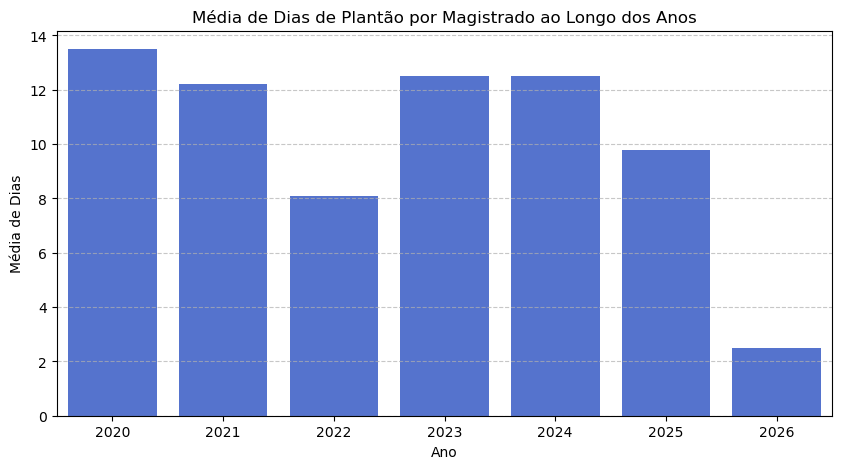

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Contar quantos dias cada magistrado trabalhou por ano
# Agrupamos por Ano e Nome, e contamos as linhas (dias)
dias_por_pessoa = df.groupby(['ano', 'Nome']).size().reset_index(name='dias_trabalhados')

# 2. Calcular a média geral por ano
media_anual = dias_por_pessoa.groupby('ano')['dias_trabalhados'].mean().reset_index()

# Renomeando para ficar bonito
media_anual = media_anual.rename(columns={'dias_trabalhados': 'Media_Dias_por_Pessoa'})
media_anual['Media_Dias_por_Pessoa'] = media_anual['Media_Dias_por_Pessoa'].round(1) # Arredonda

print("--- Média de dias de plantão por magistrado (Geral) ---")
display(media_anual)

# --- BÔNUS: Média separada por Cargo (Juiz vs Desembargador) ---
# Se quiser saber se Juízes trabalham mais que Desembargadores na média
dias_por_cargo = df.groupby(['ano', 'Cargo', 'Nome']).size().reset_index(name='dias_trabalhados')
media_por_cargo = dias_por_cargo.groupby(['ano', 'Cargo'])['dias_trabalhados'].mean().reset_index()
media_por_cargo['dias_trabalhados'] = media_por_cargo['dias_trabalhados'].round(1)

print("\n--- Média de dias quebrada por Cargo ---")
# Pivotar para facilitar leitura (Anos nas linhas, Cargos nas colunas)
tabela_cargo = media_por_cargo.pivot(index='ano', columns='Cargo', values='dias_trabalhados')
display(tabela_cargo)

# --- GRÁFICO ---
plt.figure(figsize=(10, 5))
sns.barplot(data=media_anual, x='ano', y='Media_Dias_por_Pessoa', color='royalblue')
plt.title('Média de Dias de Plantão por Magistrado ao Longo dos Anos')
plt.ylabel('Média de Dias')
plt.xlabel('Ano')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
media_anual.to_csv('Média por pessoas.csv')

In [ ]:
import pandas as pd
import unicodedata

# 1. Função de Limpeza "Nuclear"
def limpar_texto_avancado(texto):
    if pd.isna(texto) or texto == "":
        return ""
    
    texto = str(texto)
    
    # A. Normaliza caracteres (arruma acentos quebrados)
    texto = unicodedata.normalize('NFKD', texto)
    
    # B. O PASSO MAIS IMPORTANTE: Troca espaço não-quebrável por espaço normal
    texto = texto.replace('\xa0', ' ')
    
    # C. Remove tabs e quebras de linha escondidas
    texto = texto.replace('\t', ' ').replace('\n', ' ').replace('\r', ' ')
    
    # D. Remove espaços duplos e espaços nas pontas (o "TRIM" potente)
    # "  Juiz   Fulano  " vira "Juiz Fulano"
    texto = " ".join(texto.split())
    
    # E. Padroniza Maiúsculas/Minúsculas (Só a primeira letra maiúscula)
    # Isso garante que "JUIZ" e "Juiz" fiquem iguais
    return texto.title()

# 2. Aplicar no seu DataFrame (nas colunas de texto)
colunas_para_limpar = ['Nome', 'Cargo', 'Magistrado']

print("Limpando dados...")
for col in colunas_para_limpar:
    if col in df.columns:
        # Aplica a função linha por linha
        df[col] = df[col].apply(limpar_texto_avancado)

# 3. Exportar direto para Excel (.xlsx)
# CSV costuma dar problema de acentuação no Excel se não configurar bem.
# O .xlsx é nativo e mantém a limpeza que fizemos.
nome_arquivo = "./data/Plantao/Plantao 2020 à 2025.csv"

print(f"Salvando em {nome_arquivo}...")
df.to_csv(nome_arquivo, index=False)

print("Sucesso! Pode abrir o Excel e fazer a Tabela Dinâmica que vai agrupar.")

Limpando dados...
Salvando em ./data/Plantao/Plantao 2020 à 2025.csv...
Sucesso! Pode abrir o Excel e fazer a Tabela Dinâmica que vai agrupar.


In [30]:
df

,Data,ano,Magistrado,Cargo,Nome,mes,nome_mes
0,08/01/2020,2020,Des. Paulo Ricardo Bruschi,Des.,Paulo Ricardo Bruschi,1,Janeiro
1,09/01/2020,2020,Des. Paulo Ricardo Bruschi,Des.,Paulo Ricardo Bruschi,1,Janeiro
2,10/01/2020,2020,Des. Paulo Ricardo Bruschi,Des.,Paulo Ricardo Bruschi,1,Janeiro
3,11/01/2020,2020,Des. Paulo Ricardo Bruschi,Des.,Paulo Ricardo Bruschi,1,Janeiro
4,12/01/2020,2020,Des. Paulo Ricardo Bruschi,Des.,Paulo Ricardo Bruschi,1,Janeiro
...,...,...,...,...,...,...,...
5253,07/01/2026,2026,Des. Geraldo CorrêA Bastos (Criminal),Des.,Geraldo CorrêA Bastos (Criminal),1,Janeiro
5254,05/01/2026,2026,Des. Marcio Rocha Cardoso (Direito Privado),Des.,Marcio Rocha Cardoso (Direito Privado),1,Janeiro
5255,06/01/2026,2026,Des. Marcio Rocha Cardoso (Direito Privado),Des.,Marcio Rocha Cardoso (Direito Privado),1,Janeiro
5256,06/01/2026,2026,Des. Roberto Lepper (Direito Privado),Des.,Roberto Lepper (Direito Privado),1,Janeiro
